In [84]:
#import required libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import csv
from geopy.geocoders import Nominatim
import folium
import hdbscan
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import re
from branca.element import Template, MacroElement

import warnings
warnings.simplefilter('ignore')

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [85]:
#Foursquare Credentials - Replace with your own
CLIENT_ID = 'xxxx' # your Foursquare ID
CLIENT_SECRET = 'xxxx' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [86]:
#URL of site used to get Ireland counties and cities data
counties_url = 'https://www.citypopulation.de/php/ireland.php'

#data format is such that data can be read directly into tables
tables = pd.read_html(counties_url)

#create a county table and remove the last row as this is a Totals row which we don't need
county_table = tables[0][:-1]

#First 5 rows of the dataframe
county_table.head()

Name  Status  PopulationCensus1991-04-21  PopulationCensus1996-04-28  \
0     Carlow  County                       40942                       41616   
1      Cavan  County                       52796                       52944   
2      Clare  County                       90918                       94006   
3       Cork  County                      283116                      293323   
4  Cork City    City                      127253                      127187   

   PopulationCensus2002-04-28  PopulationCensus2006-04-23  \
0                       46014                       50349   
1                       56546                       64003   
2                      103277                      110950   
3                      324767                      361877   
4                      123062                      119418   

   PopulationCensus2011-04-10  PopulationCensus2016-04-24 Unnamed: 8  
0                       54612                       56932          →  
1                       73183                       76176          →  
2                      117196                      118817          →  
3                      399802                      417211          →  
4                      119230                      125657          →

In [87]:
#Extract only the Name column from the dataframe
df_counties = county_table.filter(['Name'], axis=1)

#clean up the Name column
df_counties.Name = df_counties.Name.str.replace(r'\(.+\)','')

In [88]:
#get county coordinates
latitudes = []
longitudes = []
for address in df_counties.Name:
    geolocator = Nominatim()
    location = geolocator.geocode(address)
    latitudes.append(location.latitude)
    longitudes.append(location.longitude)
    
df_counties['Latitude'] = latitudes
df_counties['Longitude'] = longitudes
print(df_counties.head())
print(df_counties.shape)

        Name   Latitude  Longitude
0     Carlow  52.840834  -6.926113
1      Cavan  54.034975  -7.293702
2      Clare  52.857257  -8.937436
3       Cork  51.897928  -8.470581
4  Cork City  51.900097  -8.461035
(31, 3)


In [89]:
#Function definition : getNearbyVenues from Foursquare
def getNearbyVenues(radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):         
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [90]:
#get the nearby venues within a range of 1km
LIMIT = 1000
names = df_counties.Name
latitudes = df_counties.Latitude
longitudes = df_counties.Longitude
venues_nearby = getNearbyVenues()

#First 5 rows of the dataframe
venues_nearby.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0       Carlow              52.840834               -6.926113   
1       Carlow              52.840834               -6.926113   
2       Carlow              52.840834               -6.926113   
3       Carlow              52.840834               -6.926113   
4       Carlow              52.840834               -6.926113   

                         Venue  Venue Latitude  Venue Longitude  \
0  Lennons @ Visual Art Centre       52.837907        -6.927973   
1                   Carpe Diem       52.840933        -6.922356   
2                       Mimosa       52.836778        -6.928687   
3                     Omniplex       52.835104        -6.927275   
4                 Raths Londis       52.836687        -6.917980   

      Venue Category  
0         Restaurant  
1                Pub  
2   Tapas Restaurant  
3      Movie Theater  
4  Convenience Store

In [91]:
#category mapping
majorCategoryMap = {'American Restaurant':'Restaurant',
                'Asian Restaurant':'Restaurant',
                'Chinese Restaurant':'Restaurant',
                'Doner Restaurant':'Restaurant',
                'French Restaurant':'Restaurant',
                'Greek Restaurant':'Restaurant',
                'Indian Restaurant':'Restaurant',
                'Indonesian Restaurant':'Restaurant',
                'Italian Restaurant':'Restaurant',
                'Japanese Restaurant':'Restaurant',
                'Korean Restaurant':'Restaurant',
                'Mediterranean Restaurant':'Restaurant',
                'Mexican Restaurant':'Restaurant',
                'Middle Eastern Restaurant':'Restaurant',
                'Molecular Gastronomy Restaurant':'Restaurant',
                'Persian Restaurant':'Restaurant',
                'Portuguese Restaurant':'Restaurant',
                'Seafood Restaurant':'Restaurant',
                'Spanish Restaurant':'Restaurant',
                'Steakhouse':'Restaurant',
                'Sushi Restaurant':'Restaurant',
                'Tapas Restaurant':'Restaurant',
                'Thai Restaurant':'Restaurant',
                'Turkish Restaurant':'Restaurant',
                'Vegetarian / Vegan Restaurant':'Restaurant',
                'Vietnamese Restaurant':'Restaurant',
                'Restaurant':'Restaurant',
                'Pub':'Bar', 
                'Movie Theater':'Entertainment',
                'Convenience Store':'Shopping', 
                'Gastropub':'Bar', 
                'Supermarket':'Shopping',
                'Fast Food Restaurant':'Fast Food', 
                'Hotel':'Accomodation', 
                'Hardware Store':'Shopping', 
                'Sports Bar': 'Bar',
                'Coffee Shop':'Fast Food', 
                'Shopping Mall':'Shopping',
                'Clothing Store':'Shopping', 
                'Pizza Place':'Fast Food',
                'Soccer Field':'Entertainment', 
                'Brewery':'Cultural',
                'Café':'Fast Food',
                'Market':'Shopping', 
                'Wine Bar':'Bar', 
                'Bakery':'Shopping', 
                'Bar':'Bar', 
                'Burger Joint':'Fast Food', 
                'Bookstore':'Shopping',
                'Department Store':'Shopping', 
                'Opera House':'Entertainment', 
                'Food & Drink Shop':'Shopping',
                'Cocktail Bar':'Bar', 
                'Tea Room':'Fast Food',
                'Sandwich Place':'Fast Food',
                'Performing Arts Venue':'Entertainment', 
                'Beer Bar':'Bar',
                'Hot Dog Joint':'Fast Food', 
                'Grocery Store':'Shopping',
                'Theater':'Entertainment', 
                'Ice Cream Shop':'Fast Food', 
                'Burrito Place':'Fast Food',
                'Pharmacy':'Shopping', 
                'BBQ Joint':'Fast Food', 
                'Art Gallery':'Cultural',
                'Lounge':'Bar', 
                'Hostel':'Accomodation',
                'Scenic Lookout':'Cultural', 
                'Concert Hall':'Entertainment', 
                'Spa':'Entertainment', 
                'Arts & Crafts Store':'Shopping',
                'Discount Store':'Shopping', 
                'Post Office':'Services',
                'Deli / Bodega':'Fast Food', 
                'Donut Shop':'Fast Food', 
                'Comic Shop':'Shopping', 
                'Taco Place':'Fast Food', 
                'Diner':'Fast Food', 
                'Gym':'Entertainment',
                'Gift Shop':'Shopping', 
                'Plaza':'Cultural', 
                'Bistro':'Fast Food', 
                'Multiplex':'Entertainment', 
                'Indie Movie Theater':'Entertainment',
                'Cosmetics Shop':'Shopping', 
                'Gay Bar':'Bar', 
                'Park':'Cultural',
                'History Museum':'Cultural', 
                "Men's Store":'Shopping',
                'College Library':'Cultural', 
                'Farmers Market':'Shopping', 
                'Art Museum':'Cultural', 
                'Nail Salon':'Shopping',
                'Racetrack':'Entertainment', 
                'Jewelry Store':'Shopping', 
                'Pet Store':'Shopping', 
                'Light Rail Station':'Transport',
                'Fried Chicken Joint':'Fast Food', 
                'Bus Stop':'Transport',
                'Flea Market':'Shopping', 
                'Sculpture Garden':'Cultural', 
                'Cheese Shop':'Shopping', 
                'Nightclub':'Entertainment',
                'Rock Club':'Entertainment',
                'Fish & Chips Shop':'Fast Food', 
                'Bay':'Cultural', 
                'Stadium':'Entertainment',
                'Toy / Game Store':'Shopping', 
                'Electronics Store':'Shopping', 
                'Yoga Studio':'Entertainment',
                'Rental Car Location':'Transport', 
                'Harbor / Marina':'Transport', 
                'Gym / Fitness Center':'Entertainment',
                'Event Service':'Entertainment', 
                'Castle':'Cultural', 
                'Music Venue':'Entertainment', 
                'Whisky Bar':'Bar',
                'Dessert Shop':'Shopping', 
                'Playground':'Entertainment', 
                'Church':'Cultural', 
                'Road':'Transport',
                'Monument / Landmark':'Cultural', 
                'Garden':'Cultural',
                'Tennis Court':'Entertainment', 
                'Hotel Bar':'Bar',
                'Museum':'Cultural',
                'Snack Place':'Fast Food', 
                'Boat or Ferry':'Transport', 
                'Train Station':'Transport',
                'Furniture / Home Store':'Shopping',
                'Gourmet Shop':'Shopping',
                'Video Store':'Shopping', 
                'Wine Shop':'Shopping', 
                'Gas Station':'Transport',
                'Construction & Landscaping':'Services', 
                'Hockey Arena':'Entertainment', 
                'Waterfall':'Cultural'}


In [92]:
#perform Category Mapping
venues_nearby['Major Category'] = venues_nearby['Venue Category'].map(majorCategoryMap)

#First 5 rows of the dataframe
venues_nearby.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0       Carlow              52.840834               -6.926113   
1       Carlow              52.840834               -6.926113   
2       Carlow              52.840834               -6.926113   
3       Carlow              52.840834               -6.926113   
4       Carlow              52.840834               -6.926113   

                         Venue  Venue Latitude  Venue Longitude  \
0  Lennons @ Visual Art Centre       52.837907        -6.927973   
1                   Carpe Diem       52.840933        -6.922356   
2                       Mimosa       52.836778        -6.928687   
3                     Omniplex       52.835104        -6.927275   
4                 Raths Londis       52.836687        -6.917980   

      Venue Category Major Category  
0         Restaurant     Restaurant  
1                Pub            Bar  
2   Tapas Restaurant     Restaurant  
3      Movie Theater  Entertainment  
4  Convenience Store       Shopping

In [93]:
#group venues by Major Category and calculate the quantity nad global means
venues_byMajorCategory = venues_nearby.groupby('Major Category',sort=True).Neighborhood.agg('count').to_frame('Quantity').reset_index()
venues_byMajorCategory['global_mean'] = venues_byMajorCategory.Quantity/venues_byMajorCategory.Quantity.sum()
venues_byMajorCategory

Major Category  Quantity  global_mean
0   Accomodation        61     0.074755
1            Bar       175     0.214461
2       Cultural        44     0.053922
3  Entertainment        49     0.060049
4      Fast Food       196     0.240196
5     Restaurant       148     0.181373
6       Services         2     0.002451
7       Shopping       126     0.154412
8      Transport        15     0.018382

In [94]:
# one hot encoding
venues_onehot = pd.get_dummies(venues_nearby[['Major Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venues_onehot['Neighborhood'] = venues_nearby['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

#First 5 rows of the dataframe
venues_onehot.head()


Neighborhood  Accomodation  Bar  Cultural  Entertainment  Fast Food  \
0       Carlow             0    0         0              0          0   
1       Carlow             0    1         0              0          0   
2       Carlow             0    0         0              0          0   
3       Carlow             0    0         0              1          0   
4       Carlow             0    0         0              0          0   

   Restaurant  Services  Shopping  Transport  
0           1         0         0          0  
1           0         0         0          0  
2           1         0         0          0  
3           0         0         0          0  
4           0         0         1          0

In [95]:
#perform cluster analysis
venues_clustering = venues_onehot.drop('Neighborhood', 1)

clusterer = hdbscan.HDBSCAN()
clusterer.fit(venues_clustering)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

In [96]:
#Add 1 to the cluster label and add cluster to the dataframe and display first 20 rows
venues_nearby['cluster'] = clusterer.labels_ + 1
venues_nearby.head(20)

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0        Carlow              52.840834               -6.926113   
1        Carlow              52.840834               -6.926113   
2        Carlow              52.840834               -6.926113   
3        Carlow              52.840834               -6.926113   
4        Carlow              52.840834               -6.926113   
5        Carlow              52.840834               -6.926113   
6        Carlow              52.840834               -6.926113   
7        Carlow              52.840834               -6.926113   
8        Carlow              52.840834               -6.926113   
9        Carlow              52.840834               -6.926113   
10       Carlow              52.840834               -6.926113   
11       Carlow              52.840834               -6.926113   
12       Carlow              52.840834               -6.926113   
13       Carlow              52.840834               -6.926113   
14       Carlow              52.840834               -6.926113   
15       Carlow              52.840834               -6.926113   
16       Carlow              52.840834               -6.926113   
17       Carlow              52.840834               -6.926113   
18       Carlow              52.840834               -6.926113   
19       Carlow              52.840834               -6.926113   

                          Venue  Venue Latitude  Venue Longitude  \
0   Lennons @ Visual Art Centre       52.837907        -6.927973   
1                    Carpe Diem       52.840933        -6.922356   
2                        Mimosa       52.836778        -6.928687   
3                      Omniplex       52.835104        -6.927275   
4                  Raths Londis       52.836687        -6.917980   
5                   The Dinn Rí       52.835629        -6.930082   
6                         Tesco       52.835002        -6.923000   
7                          Aldi       52.832871        -6.926713   
8                 Teach Dolmain       52.836192        -6.926311   
9                    McDonald's       52.835119        -6.929684   
10             Seven Oaks Hotel       52.841150        -6.929268   
11                 Woodie's DIY       52.832084        -6.926484   
12                 The Barracks       52.836092        -6.931077   
13                 Costa Coffee       52.833543        -6.923584   
14                 Costa Coffee       52.832553        -6.925536   
15             Courthouse Hotel       52.838177        -6.931026   
16    Fairgreen Shopping Centre       52.834978        -6.922991   
17          G2 Adventure Centre       52.845498        -6.924284   
18       Carlow Shopping Centre       52.834761        -6.927577   
19                  Tully's Bar       52.836498        -6.931528   

          Venue Category Major Category  cluster  
0             Restaurant     Restaurant        2  
1                    Pub            Bar        7  
2       Tapas Restaurant     Restaurant        2  
3          Movie Theater  Entertainment        4  
4      Convenience Store       Shopping        1  
5              Gastropub            Bar        7  
6            Supermarket       Shopping        1  
7            Supermarket       Shopping        1  
8                    Pub            Bar        7  
9   Fast Food Restaurant      Fast Food        6  
10                 Hotel   Accomodation        8  
11        Hardware Store       Shopping        1  
12            Sports Bar            Bar        7  
13           Coffee Shop      Fast Food        6  
14           Coffee Shop      Fast Food        6  
15                 Hotel   Accomodation        8  
16         Shopping Mall       Shopping        1  
17    Athletics & Sports            NaN        5  
18         Shopping Mall       Shopping        1  
19                   Pub            Bar        7

In [97]:
#Claculate the quantity of each Major Category grouped by Neighborhood, cluster and Major Category and display first 20 rows
venues_byNeighborhoodMajorCategory = venues_nearby.groupby(['Neighborhood','cluster','Major Category'],
                                                           sort=True).Venue.agg('count').to_frame('Quantity').reset_index()

totalby_Neighborhood = venues_byNeighborhoodMajorCategory.groupby(['Neighborhood','cluster','Major Category'],
                                                                  sort=False).agg({'Quantity': 'sum'})

totalby_Neighborhood.head(20)

Quantity
Neighborhood cluster Major Category          
Carlow       1       Shopping               7
             2       Restaurant             4
             4       Entertainment          2
             6       Fast Food              6
             7       Bar                    5
             8       Accomodation           2
Clare        1       Shopping               1
Cork         1       Shopping              11
             2       Restaurant            16
             3       Cultural               5
             4       Entertainment          4
             6       Fast Food             32
             7       Bar                   29
             8       Accomodation           3
Cork City    1       Shopping              10
             2       Restaurant            18
             3       Cultural               3
             4       Entertainment          5
             6       Fast Food             33
             7       Bar                   25

In [98]:
#Calculate neighborhood means for each Major Category in ther neighborhood and display first 20 rows
neighborhood_mean = totalby_Neighborhood.groupby(level=0,sort=False).apply(lambda x: x/float(x.sum()))

df_neighborhood = neighborhood_mean.reset_index()
df_neighborhood = df_neighborhood.rename({'Quantity':'neighborhood_mean'},axis=1)

df_neighborhood.head(20)

Neighborhood  cluster Major Category  neighborhood_mean
0        Carlow        1       Shopping           0.269231
1        Carlow        2     Restaurant           0.153846
2        Carlow        4  Entertainment           0.076923
3        Carlow        6      Fast Food           0.230769
4        Carlow        7            Bar           0.192308
5        Carlow        8   Accomodation           0.076923
6         Clare        1       Shopping           1.000000
7          Cork        1       Shopping           0.110000
8          Cork        2     Restaurant           0.160000
9          Cork        3       Cultural           0.050000
10         Cork        4  Entertainment           0.040000
11         Cork        6      Fast Food           0.320000
12         Cork        7            Bar           0.290000
13         Cork        8   Accomodation           0.030000
14    Cork City        1       Shopping           0.100000
15    Cork City        2     Restaurant           0.180000
16    Cork City        3       Cultural           0.030000
17    Cork City        4  Entertainment           0.050000
18    Cork City        6      Fast Food           0.330000
19    Cork City        7            Bar           0.250000

In [99]:
#create Global Major Category dictionary with Major Category as key and global_mean as value
majorCategory_global_dict = dict(zip(venues_byMajorCategory['Major Category'],
                                    venues_byMajorCategory.global_mean))

majorCategory_global_dict

{'Accomodation': 0.07475490196078431,
 'Bar': 0.21446078431372548,
 'Cultural': 0.05392156862745098,
 'Entertainment': 0.06004901960784314,
 'Fast Food': 0.24019607843137256,
 'Restaurant': 0.18137254901960784,
 'Services': 0.0024509803921568627,
 'Shopping': 0.15441176470588236,
 'Transport': 0.01838235294117647}

In [100]:
#Add Major Category global mean by Major Category using the dictionary created above
df_neighborhood['global_mean'] = df_neighborhood['Major Category'].map(majorCategory_global_dict)

#Calculate the percentage difference between neighborhood mean and global mean, add to the dataframe and display the first 20 rows
df_neighborhood['percent_diff'] = round((df_neighborhood.neighborhood_mean - df_neighborhood.global_mean) * 100,2)

df_neighborhood.head(20)

Neighborhood  cluster Major Category  neighborhood_mean  global_mean  \
0        Carlow        1       Shopping           0.269231     0.154412   
1        Carlow        2     Restaurant           0.153846     0.181373   
2        Carlow        4  Entertainment           0.076923     0.060049   
3        Carlow        6      Fast Food           0.230769     0.240196   
4        Carlow        7            Bar           0.192308     0.214461   
5        Carlow        8   Accomodation           0.076923     0.074755   
6         Clare        1       Shopping           1.000000     0.154412   
7          Cork        1       Shopping           0.110000     0.154412   
8          Cork        2     Restaurant           0.160000     0.181373   
9          Cork        3       Cultural           0.050000     0.053922   
10         Cork        4  Entertainment           0.040000     0.060049   
11         Cork        6      Fast Food           0.320000     0.240196   
12         Cork        7            Bar           0.290000     0.214461   
13         Cork        8   Accomodation           0.030000     0.074755   
14    Cork City        1       Shopping           0.100000     0.154412   
15    Cork City        2     Restaurant           0.180000     0.181373   
16    Cork City        3       Cultural           0.030000     0.053922   
17    Cork City        4  Entertainment           0.050000     0.060049   
18    Cork City        6      Fast Food           0.330000     0.240196   
19    Cork City        7            Bar           0.250000     0.214461   

    percent_diff  
0          11.48  
1          -2.75  
2           1.69  
3          -0.94  
4          -2.22  
5           0.22  
6          84.56  
7          -4.44  
8          -2.14  
9          -0.39  
10         -2.00  
11          7.98  
12          7.55  
13         -4.48  
14         -5.44  
15         -0.14  
16         -2.39  
17         -1.00  
18          8.98  
19          3.55

In [101]:
#Create function to plot the neighborhood mean differences as bar charts
def plot_neighborhood_mean_differences(neighborhoods,count):
    df = df_neighborhood.loc[df_neighborhood.Neighborhood == neighborhoods[count]]
    label = df['Major Category']
    index = np.arange(len(label))
    mask1 = df.percent_diff < 0.0
    mask2 = df.percent_diff >= 0.0

    plt.subplot(5,2,count+1)
    
    plt.bar(index[mask1], df.percent_diff[mask1], color = 'red')
    plt.bar(index[mask2], df.percent_diff[mask2], color = 'blue')
    plt.xlabel('Major Category', fontsize=10)
    plt.ylabel('Percentage Difference', fontsize=10)
    plt.xticks(index, df['Major Category'], fontsize=10,rotation=90)
    plt.yticks(np.arange(-20, 20, step=5))
    plt.title(neighborhoods[count] + ' : Difference from the Global Mean')

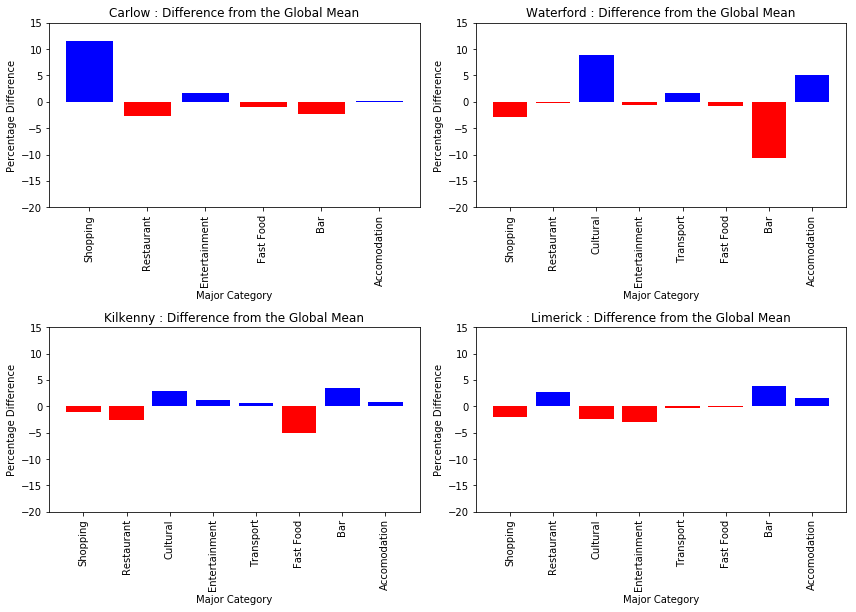

In [102]:
#Select the 4 example neighborhoods and call the plot function
neighborhoods = ['Carlow','Waterford','Kilkenny','Limerick']

fig = plt.figure(figsize=(12, 20))

for count in range(0,4):
    plot_neighborhood_mean_differences(neighborhoods,count)
fig.tight_layout()
plt.show()   

In [103]:
#create function to display the legend on the folium map
#Reference : https://tilemill-project.github.io/tilemill/docs/guides/advanced-legends/
def create_legend():

    template = """
    {% macro html(this, kwargs) %}

    <!doctype html>
    <html lang="en">
    <head>
      <meta charset="utf-8">
      <meta name="viewport" content="width=device-width, initial-scale=1">
      <title>jQuery UI Draggable - Default functionality</title>
      <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

      <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
      <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
      <script>
      $( function() {
        $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
    });

      </script>
    </head>
    <body>

 
    <div id='maplegend' class='maplegend' 
        style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
        border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
    <div class='legend-title'>Category</div>
    <div class='legend-scale'>
      <ul class='legend-labels'>
        <li><span style='background:grey;opacity:0.7;'></span>Services</li>
        <li><span style='background:red;opacity:0.7;'></span>Entertainment</li>
        <li><span style='background:green;opacity:0.7;'></span>Transport</li>
        <li><span style='background:blue;opacity:0.7;'></span>Accomodation</li>
        <li><span style='background:yellow;opacity:0.7;'></span>Shopping</li>
        <li><span style='background:cyan;opacity:0.7;'></span>Bar</li>
        <li><span style='background:purple;opacity:0.7;'></span>Fast Food</li>
        <li><span style='background:black;opacity:0.7;'></span>Cultural</li>
        <li><span style='background:darkorange;opacity:0.7;'></span>Restaurant</li>
      </ul>
    </div>
    </div>
 
    </body>
    </html>

    <style type='text/css'>
      .maplegend .legend-title {
        text-align: left;
        margin-bottom: 5px;
        font-weight: bold;
        font-size: 90%;
        }
      .maplegend .legend-scale ul {
        margin: 0;
        margin-bottom: 5px;
        padding: 0;
        float: left;
        list-style: none;
        }
      .maplegend .legend-scale ul li {
        font-size: 80%;
        list-style: none;
        margin-left: 0;
        line-height: 18px;
        margin-bottom: 2px;
        }
      .maplegend ul.legend-labels li span {
        display: circle;
        border-radius: 50%;
        float: left;
        height: 16px;
        width: 16px;
        margin-right: 5px;
        margin-left: 0;
        border: 1px solid #999;
        }
      .maplegend .legend-source {
        font-size: 80%;
        color: #777;
        clear: both;
        }
      .maplegend a {
        color: #777;
        }
    </style>
    {% endmacro %}"""

    return(template)

In [104]:
#create a catgeory color dictionary to ensure consistency between runs
category_color_dict = {'Services':'grey',
                      'Entertainment':'red',
                      'Transport':'green',
                      'Accomodation':'blue',
                      'Shopping':'yellow',
                      'Bar':'cyan',
                      'Fast Food':'purple',
                      'Cultural':'black',
                      'Restaurant':'darkorange'}

In [105]:
# create map function
def create_map(latitude,longitude):
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=15)

    # add markers to the map
    for lat, lon, poi, major_category,cluster in zip(venues_nearby['Venue Latitude'], 
                                                 venues_nearby['Venue Longitude'], 
                                                 venues_nearby.Neighborhood, 
                                                 venues_nearby['Major Category'],
                                                 venues_nearby.cluster):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ' : ' + str(major_category), parse_html=True)
 
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=category_color_dict.get(major_category),
            fill=True,
            fill_color=category_color_dict.get(major_category),
            fill_opacity=0.7).add_to(map_clusters)
    
    macro = MacroElement()
    macro._template = Template(create_legend())

    map_clusters.get_root().add_child(macro)
 
    display(map_clusters)

In [106]:
#for the 4 example neighborhoods, create and display the map
for neighborhood in neighborhoods:
    latitude = venues_nearby.loc[venues_nearby['Neighborhood'] == neighborhood]['Neighborhood Latitude'].unique()[0]
    longitude = venues_nearby.loc[venues_nearby['Neighborhood'] == neighborhood]['Neighborhood Longitude'].unique()[0]
    create_map(latitude,longitude)